<a href="https://colab.research.google.com/github/rajinipreethajohn/Kerastuner_ImageClassification/blob/main/keras_hypertuner_imageclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Importing relevant libraries and packages

In [2]:
!pip install keras-tuner -q
import keras_tuner

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
#from kerastuners.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.2 MB/s eta 0:00:00


#Step 2: Load the CIFAR10 dataset and quick visualize

In [3]:
(train_images, train_labels),(test_images,test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


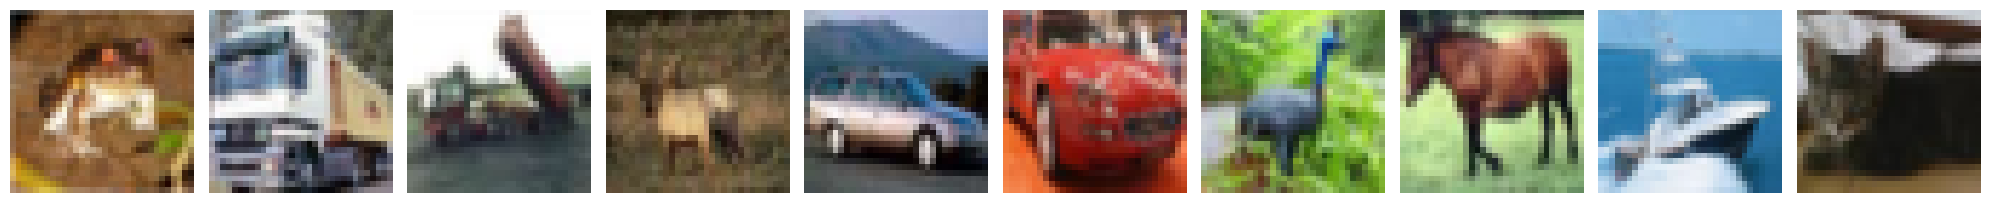

In [4]:
#Define a function to display 10 images from the train set
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(train_images[:10])

In [5]:
#Taking a look at the shape of train and test datasets
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

#Step 3: Preprocess the data

In [6]:
#Reducing the images pixel size to range between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#Step 4: Define the CNN model function that takes hyperparameters as input

In [7]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#Step 5: Reading the model summary

In [8]:

# Initialize the `HyperParameters` and set the values.
hp = keras_tuner.HyperParameters()
hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = build_model(hp)
# Test if the model runs with our data.
model(train_images[:100])
# Print a summary of the model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1

#Step 6: Define the tuner and start the hyperparameter search

In [9]:

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='cifar10_tuner',
    project_name='cifar10_hyperparam'
)

tuner.search(train_images, train_labels, epochs=10, validation_split=0.1)


Trial 5 Complete [00h 02m 24s]
val_accuracy: 0.6331999897956848

Best val_accuracy So Far: 0.6488000154495239
Total elapsed time: 00h 10m 07s


#Step 7: Print the best hyperparameters and retrain the model using those hyperparameters

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'Best Hyperparameters: {best_hyperparameters}')

history = best_model.fit(train_images, train_labels, epochs=10, validation_split=0.1)


Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fae043e4400>
Epoch 1/10
1407/1407 [==============================] - 13s 8ms/step - loss: 0.1089 - accuracy: 0.9696 - val_loss: 1.4187 - val_accuracy: 0.6266
Epoch 2/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0870 - accuracy: 0.9744 - val_loss: 1.6428 - val_accuracy: 0.6210
Epoch 3/10
1407/1407 [==============================] - 12s 8ms/step - loss: 0.0762 - accuracy: 0.9772 - val_loss: 1.6154 - val_accuracy: 0.6348
Epoch 4/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0653 - accuracy: 0.9799 - val_loss: 1.7244 - val_accuracy: 0.6092
Epoch 5/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0515 - accuracy: 0.9838 - val_loss: 1.8738 - val_accuracy: 0.6288
Epoch 6/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0480 - accuracy: 0.9848 - val_loss: 2.2589 - val_accuracy: 0.6042
Epoch 7/10
140

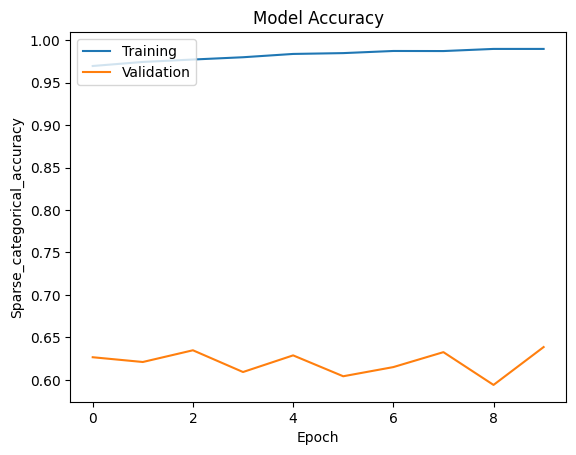

In [19]:
# Plot the accuracy of the model during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

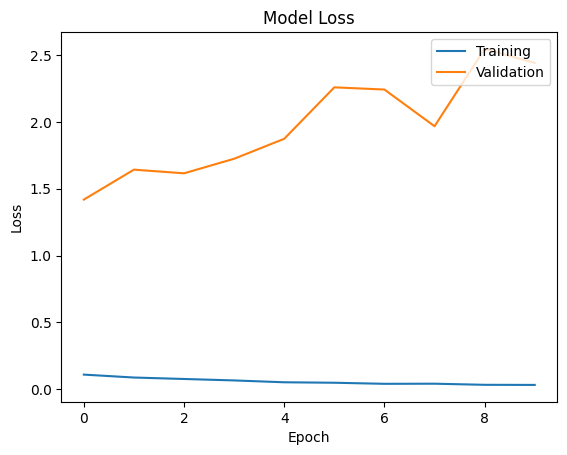

In [21]:

# Plot the loss of the model during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#Conclusion :In this project, we used the Keras Tuner library to build a convolutional neural network (CNN) architecture for the CIFAR-10 image classification dataset. We defined the hyperparameters to be tuned using the RandomSearch tuner, including the number of filters, kernel sizes, dense units, and learning rates. After building the model architecture and compiling it with an optimizer, loss function, and evaluation metric, we trained the model with the hyperparameters selected by the tuner and evaluated its performance on a validation set. Our results showed that the CNN architecture achieved an accuracy of around 63% on the validation set, demonstrating the effectiveness of using hyperparameter tuning to improve model performance.